In [2]:
# Import the organization modules
import pandas as pd
import numpy as np
# Import module to ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Import the plot modules
import matplotlib.pyplot as plt
import seaborn as sns
# Import own scripts
from scripts.data_cleaning import (
    read_all_csvs, 
    clean_data,
    create_csv
    )

In [3]:
# Imports
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, fbeta_score, get_scorer_names

from xgboost import XGBClassifier

In [4]:
# Create data frame from all single CSV files
df = read_all_csvs()
# Clean the data
df = clean_data(df)

In [5]:
features = df.columns.to_list()
features.remove('state')
X = df[features]
y = df.state


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [6]:
y_train = np.where(y_train == "successful", 1, 0)
y_test = np.where(y_test == "successful", 1, 0)

In [7]:
# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(MinMaxScaler(), XGBClassifier())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [8]:
print("f_beta_score: ", fbeta_score(y_test, y_pred, beta = 2, average = 'macro').round(2))

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)

f_beta_score:  0.81
Accuracy on train set: 0.82
Accuracy on test set: 0.81
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     25014
           1       0.85      0.78      0.81     28378

    accuracy                           0.81     53392
   macro avg       0.81      0.81      0.81     53392
weighted avg       0.81      0.81      0.81     53392

--------------------------------------------------------------------------------


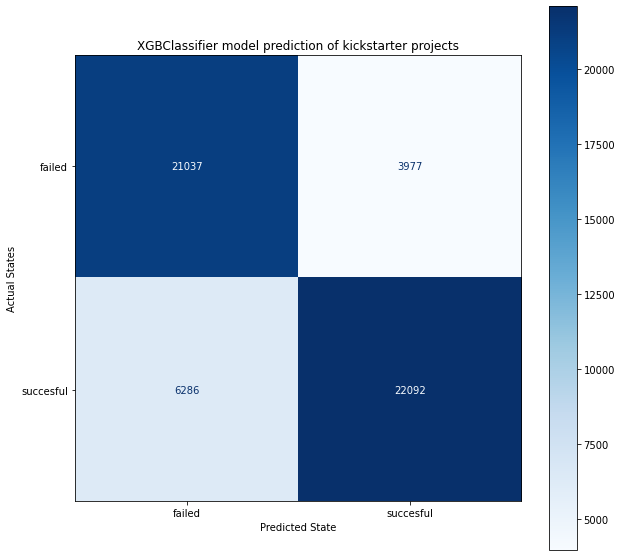

In [9]:
## Create the Confusion Matrix Display Object(cmd_obj)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['failed', 'succesful'])
## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
fig, ax = plt.subplots(figsize=(10,10))

## Set the color
cmd_obj.plot(ax=ax, cmap = 'Blues')
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='XGBClassifier model prediction of kickstarter projects', 
                xlabel='Predicted State', 
                ylabel='Actual States',
                )
## Finally, call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.show()

In [10]:
# let's create a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_train.columns, clf.steps[1][1].feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [11]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

feat_df

,Feature,Importance
0,category_sub_web,0.019268
1,category_food,0.018730
2,category_sub_documentary,0.017977
3,category_sub_nonfiction,0.017625
4,category_sub_indie rock,0.017612
...,...,...
400,category_sub_typography,0.000000
401,category_sub_vegan,0.000000
402,category_sub_video art,0.000000
403,category_sub_weaving,0.000000


In [12]:
feat_df_top_10 = feat_df.head(10)

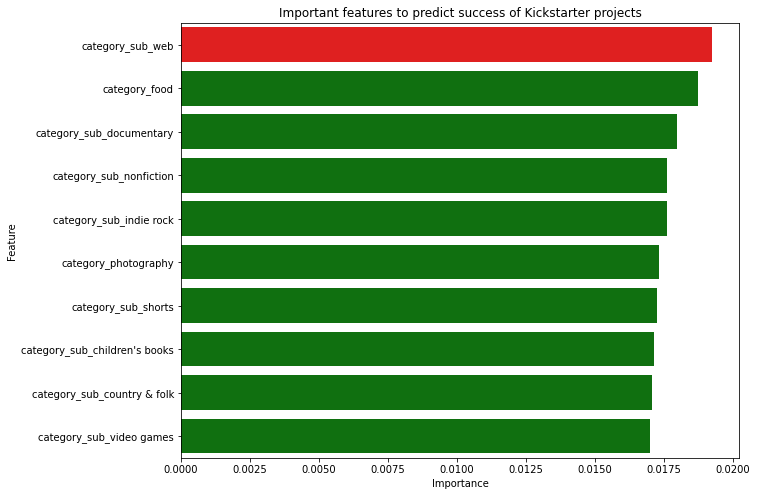

In [15]:
values = feat_df_top_10.Importance    
idx = feat_df_top_10.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict success of Kickstarter projects')
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Various hyper-parameters to tune
xgb1 = XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[12:24:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:24:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [18]:
y_pred = xgb_grid.predict(X_test)
y_pred_train = xgb_grid.predict(X_train)

In [19]:
print("f_beta_score: ", fbeta_score(y_test, y_pred, beta = 2, average = 'macro').round(2))

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)

f_beta_score:  0.82
Accuracy on train set: 0.85
Accuracy on test set: 0.82
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     25014
           1       0.86      0.79      0.82     28378

    accuracy                           0.82     53392
   macro avg       0.82      0.82      0.82     53392
weighted avg       0.82      0.82      0.82     53392

--------------------------------------------------------------------------------


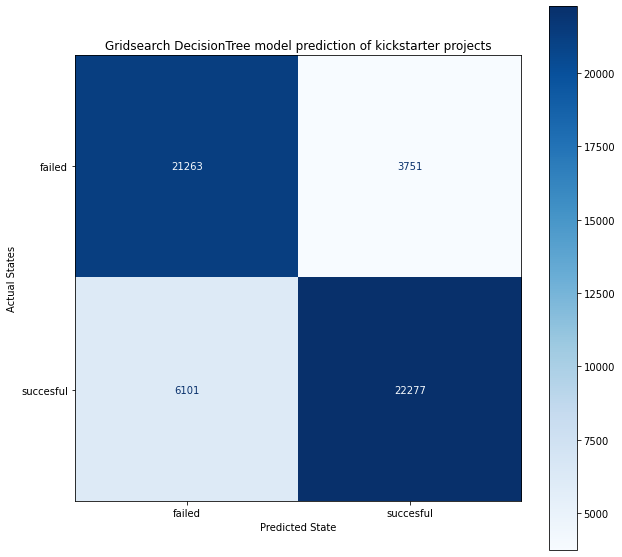

In [20]:
## Create the Confusion Matrix Display Object(cmd_obj)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['failed', 'succesful'])
## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
fig, ax = plt.subplots(figsize=(10,10))

## Set the color
cmd_obj.plot(ax=ax, cmap = 'Blues')
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='Gridsearch DecisionTree model prediction of kickstarter projects', 
                xlabel='Predicted State', 
                ylabel='Actual States',
                )
## Finally, call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.show()